# Time Series Analysis

This notebook estimates autocorrelations and different time series models (AR, MA and VAR).

## Load Packages and Extra Functions

This notebook uses the [StatsBase.jl](https://github.com/JuliaStats/StatsBase.jl) package for estimating autocorrelations.

In [1]:
using Printf, DelimitedFiles, LinearAlgebra, Distributions, StatsBase

include("jlFiles/printmat.jl")
include("jlFiles/UtilityFunctions.jl")
include("jlFiles/TimeSeriesFilter.jl")   #impulse response functions etc
include("jlFiles/TimeSeriesExtra.jl");   #miscellaneous time series functions

In [2]:
using Plots

gr(size=(480,320))
default(fmt = :png)

## Load Data

In [3]:
xx  = readdlm("Data/RvSP500.csv",',',skipstart=1)
y   = xx[:,3]            #SP500 log realized monthly volatility
xx  = nothing

T   = size(y,1)
println("Sample size: $T")

Sample size: 574


# Descriptive Statistics

## Autocorrelations

The $s\text{th}$ autocorrelation $\rho_s$ is the correlation of $y_{t}$ and $y_{t-s}$. It is a useful tool for describing the properties of data.

It can be shown that the t-stat of an autocorrelation is $\sqrt{T} \rho_s$.

We can (jointly) test the first $L$ autocorrelations by the Box-Pierce test, which (under the null hypothesis of no autocorrelation) has a $\chi^2_L$ distribution.

In [4]:
L = 5
lags = 1:L
ρ = autocor(y,lags)         #using the StatsBase package

printblue("Autocorrelations:\n")
printmat(ρ,sqrt(T)*ρ;colNames=["autocorrr","t-stat"],rowNames=lags,cell00="lag")

BP = T*sum(ρ.^2)            #the Box-Pierce test statistic

printblue("Box-Pierce test:\n")
printmat(BP,quantile(Chisq(L),0.9);rowNames=["test statistic","10% critical value"])

Autocorrelations:

lag autocorrr    t-stat
1       0.709    16.982
2       0.602    14.419
3       0.529    12.684
4       0.459    11.000
5       0.455    10.903

Box-Pierce test:

test statistic       897.040     9.236



test statistic       897.040     9.236



# White Noise

A white noise process is supposed to have no autocorrelation and have fixed means and volatilities, so the only parameters are the mean and the standard deviation (or variance).

Estimation: traditional sample mean and standard deviation.

In [5]:
μ = mean(y)
σ = std(y)

printlnPs("Mean and std:",μ,σ)

Mean and std:     2.567     0.437


# AR(p)

This section discusses the properties and estimation of autoregressive (AR) processes.

## Impulse Response Function of AR Processes

The next cell shows how a shock to an AR process propagates over time, the *impulse response function*. This is a useful tool for understanding the properties of the model.

The two models used here are an AR(1)

$
y_t = a y_{t-1} + \epsilon_t
$

and an AR(2)

$
y_t = a_1 y_{t-1} + a_2 y_{t-2} + \epsilon_t.
$

The impulse response function is calculated by setting $\epsilon_0=1$ but all other $\epsilon_t=0$ and then looping over time. For *stationary models*, the impulse response function eventually converges to zero. That is, the effect of a shock eventually disappears.


### A Remark on the Code

- To be consistent with the lecture notes, the shock will happen in period 0, which will correspond to `ϵ[3]` below. Notice that typical Julia vectors starts at index 1. (The [OffsetArrays.jl](https://github.com/JuliaArrays/OffsetArrays.jl) package allows more flexible indexing, but it's not used here.) 

In [6]:
a = 0.85               #AR(1)
(a₁,a₂) = (0.85,-0.5)  #AR(2)

τ_max  = 11
period = -2:(τ_max-3)       #-2,-1,0,1,...

ϵ    = zeros(τ_max)
ϵ[3] = 1                     #a single shock at period=0, which is at index τ=3, otherwise zeros

(y1,y2) = (copy(ϵ),copy(ϵ))
for τ = 3:τ_max                 #loop starts at τ=3 (period=0)
    y1[τ] = a*y1[τ-1] + ϵ[τ]
    y2[τ] = a₁*y2[τ-1] + a₂*y2[τ-2] + ϵ[τ]
end

printblue("The impulse responses:\n")
printmat([y1 y2];colNames=["AR(1)","AR(2)"],rowNames=period,cell00="period")

printred("However, we only plot period 0 and onwards")

The impulse responses:

period     AR(1)     AR(2)
-2         0.000     0.000
-1         0.000     0.000
0          1.000     1.000
1          0.850     0.850
2          0.722     0.222
3          0.614    -0.236
4          0.522    -0.312
5          0.444    -0.147
6          0.377     0.031
7          0.321     0.100
8          0.272     0.069

However, we only plot period 0 and onwards


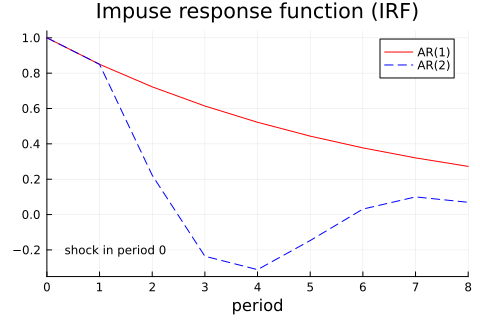

In [7]:
p1 = plot( period,[y1 y2],
           label = ["AR(1)" "AR(2)"],
           linecolor = [:red :blue],
           linestyle = [:solid :dash],
           xticks = period,
           xlims = (0,8),                  #plot only period 0-
           xlabel = "period",
           title = "Impuse response function (IRF)",
           annotation = (1.3,-0.2,text("shock in period 0",8)) )
display(p1)

## The Roots of an AR Model (extra)

The *roots* of an AR(p) is a formal way of determining whether it is stationary. (A informal way is to check whether the impulse response function goes to zero as the horizon is extended.)

An easy way to calculate the roots is to first transform the AR(p) to a V(ector)AR(1) (also called companion form) and then calculate the eigenvalues. If their absolute values are lower than one, then the model is stationary.

For instance, an AR(2)

$
y_t = a_1 y_{t-1} + a_2 y_{t-2} + \epsilon_t.
$

can be written as a 2-variable VAR(1) 

$
z_t = A_1 z_{t-1} + u_t,
$

where 

$
z_t = 
\begin{bmatrix} 
y_t \\ 
y_{t-1}  
\end{bmatrix} 
\text{ and }
A_1 = 
\begin{bmatrix} 
a_1 & a_2\\ 
1 & 0 
\end{bmatrix}.
$

This is done in the `CompanionFormAR(a)` function (included above).

In [8]:
display("text/markdown",@doc CompanionFormAR)     #print function documentation

```
CompanionFormAR(a)
```

Companion form of AR(p), that is, write an AR(p) as a VAR(1)


In [9]:
λ = eigen(CompanionFormAR([a₁,a₂])).values    #eigenvalues of the companion form

println("absolute values of the eigenvalues: should be < 1 for stationarity")
printmat(abs.(λ))

absolute values of the eigenvalues: should be < 1 for stationarity
     0.707
     0.707



## Estimation of an AR Process

AR models can be estimated by OLS. 

The `ARpEst(y,p)` function (included above) provides a simple way of doing this.

In [10]:
display("text/markdown",@doc ARpEst)

```
ARpEst(y,p)
```

Estimate an AR(p) model (with an intercept) on the data in a vector `y`.

Output: the slope coefficients (not the intercept).


In [11]:
aAR1 = ARpEst(y,1)
aAR2 = ARpEst(y,2)

printlnPs("Estimated AR(1) coef: ",aAR1)
printlnPs("Estimated AR(2) coefs: ",aAR2)

Estimated AR(1) coef:      0.713
Estimated AR(2) coefs:      0.569     0.204


## Forecasting with an AR Process

Forecasts can be calculated recursively. For instance, for an AR(2) and data on $(y_{-1},y_0$), we can calculate the forecast for $t=1$ as 

$
\textrm{E}_0 y_1 = a_1 y_0 + a_2 y_{-1}.
$

Then, the forecast for $t=2$ (still based on the information in $t=0$) is 

$
\textrm{E}_0 y_2 = a_1 \textrm{E}_0 y_1 + a_2 y_0,
$

where $\textrm{E}_0 y_1$ is from the first forecast.

Since $\textrm{E}_0 y_0 = y_0$, this can be written on a recursive form as 

$
\textrm{E}_0 y_\tau = a_1 \textrm{E}_0 y_{\tau-1} + a_2 \textrm{E}_0 y_{\tau-2}.
$

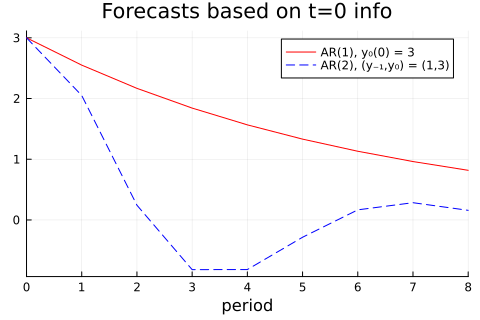

In [12]:
a = 0.85               #AR(1)
(a₁,a₂) = (0.85,-0.5)  #AR(2)

τ_max  = 11
period = -2:(τ_max-3)       #-2,-1,0,1,...

y1    = zeros(τ_max)                  #forecasts from AR(1)
y1[3] = 3
for τ = 4:τ_max                       #loop starts at τ=4 (period=1)
    y1[τ] = a*y1[τ-1]
end

y2      = zeros(τ_max)                #forecast from AR(2)
y2[2:3] = [1,3]
for τ = 4:τ_max                       #loop starts at τ=4 (period=1)
    y2[τ] = a₁*y2[τ-1] + a₂*y2[τ-2]
end

p1 = plot( [period period],[y1 y2],
           label = ["AR(1), y₀(0) = 3" "AR(2), (y₋₁,y₀) = (1,3)"],
           linecolor = [:red :blue],
           linestyle = [:solid :dash],
           xticks = period,
           xlims = (0,8),            #plotting period 0 and onwards
           xlabel = "period",
           title = "Forecasts based on t=0 info" )
display(p1)

# A Remark on the Code

- As an alternative to the loop, the `ARMAFilter(ϵ,rho=[],θ=[],θ₀=1.0,y₀=[])` funtion can be used instead. This file was included above. Notice that this function cuts the initial values, so the results need to padded with those.

The function simulates `ARMA(p,q)` models. For instance, an `ARMA(1,1)` is

$ y_t = \rho y_{t-1} + \theta_0 \epsilon_{t} + \theta \epsilon_{t-1}$,

where $\theta_0$ is the coefficient of the period-$t$ shock (often 1), while $\rho$ and $\theta$ (possibly vectors) are the coefficients for the AR and MA parts, respectively.

In [13]:
display("text/markdown",@doc ARMAFilter)

```
ARMAFilter(ϵ,rho=[],θ=[],θ₀=1.0,y₀=[])
```

Calculate ARMA(p,q) transformation of an input series ϵ. Uses explicit loop (instead of DSP.filt).

### Input

  * `ϵ::Vector`:      T-vector with an input series
  * `rho::Vector`:    (optional) p-vector of autoregression coefficients, could be []
  * `θ::Vector`:      (optional) q-vector of moving average coefficients (lag 1 to q), could be []
  * `θ₀::Number`:     (optional) scalar, coefficient on ϵ[t] in MA part, [1]
  * `y₀::Vector`:     (optional) p-vector, initial values of y, eg. [y(-1);y(0)], default: zeros(p)

### Output

  * `y::Vector`:      T-vector with output from the filter

### Notice

1. The process is `y[t] = rho[1]*y[t-1] + ... + rho[p]*y[t-p] + θ₀*ϵ[t]  +  θ[1]*ϵ[t-1] + ... + θ[q]*ϵ[t-q]`
2. The initial values of `ϵ` are assumed to be zero
3. To calculate impulse response functions, use `ϵ = [1;zeros(T-1,1)]`
4. There are no initial values in a pure MA and the case of `q > p` is handled with padding with zeros (see the code below)


In [14]:
y2b = ARMAFilter(zeros(τ_max-3),[a₁,a₂],[],1,[1,3])
y2b = [0;1;3;y2b]             #pad with the initial values

printblue("We can also use the ARMAFilter() function to do the forecasts:\n")
printmat(y2,y2b;colNames=["loop","ARMAFilter()"],rowNames=-2:8,cell00="period",width=13)

We can also use the ARMAFilter() function to do the forecasts:

period         loop ARMAFilter()
-2            0.000        0.000
-1            1.000        1.000
0             3.000        3.000
1             2.050        2.050
2             0.242        0.242
3            -0.819       -0.819
4            -0.817       -0.817
5            -0.285       -0.285
6             0.166        0.166
7             0.284        0.284
8             0.158        0.158



## More Descriptive Statistics: Partial Autocorrelations

The partial autocorrelation coefficient is the regression coefficients on $x_{t-p}$ in an AR(p) regression, that is, on the last regressor. It is a useful tool for describing the properties of your data.

In [15]:
pac = pacf(y,lags)        #from the StatsBase package

printblue("autocorrelations and  partial autocorrelations:\n")
printmat(ρ,pac;colNames=["autocorr","pac"],rowNames=lags,cell00="lag")

printred("ρ[1] and pac[1] are very similar: in a large sample they would be almost the same")

autocorrelations and  partial autocorrelations:

lag  autocorr       pac
1       0.709     0.713
2       0.602     0.204
3       0.529     0.103
4       0.459     0.031
5       0.455     0.130

ρ[1] and pac[1] are very similar: in a large sample they would be almost the same


# MA(q)

This section discusses the properties and estimation of moving average (MA) processes.

## The Impulse Response Function of an MA(q) Process

goes to zero at lag $q+1$.

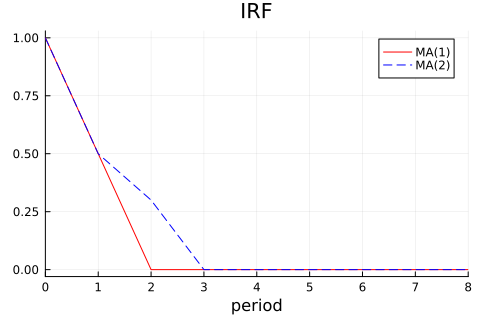

In [16]:
θ = 0.5              #MA(1)
(θ₁,θ₂) = (0.5,0.3)  #MA(2)

τ_max  = 11
period = -2:(τ_max-3)       #-2,-1,0,1,...

ϵ    = zeros(τ_max)
ϵ[3] = 1                     #a single shock, otherwise zeros

(y1,y2) = (copy(ϵ),copy(ϵ))  #MA(1) and MA(2)
for τ = 3:τ_max              #loop starts at τ=3 (period=0)
    y1[τ] = ϵ[τ] + θ*ϵ[τ-1]
    y2[τ] = ϵ[τ] + θ₁*ϵ[τ-1] + θ₂*ϵ[τ-2]   #or y2=ARMAFilter(ϵ,[],[θ₁,θ₂])
end

p1 = plot( period,[y1 y2],
           label = ["MA(1)" "MA(2)"],
           linecolor = [:red :blue],
           linestyle = [:solid :dash],
           xticks = period,
           xlims = (0,8),        #period 0 and onwards
           xlabel = "period",
           title = "IRF" )
display(p1)

## Estimation of an MA(q) (extra)

To estimate an MA model, we can apply MLE. For the numerical optimization we use the [Optim.jl](https://github.com/JuliaNLSolvers/Optim.jl) package. 

The `MAqLL(par,y)` function (included above) calculates the likelihood function and returns it as its first output.

In [17]:
using Optim

par0 = [0.5,0.3,0,0,1]   #θ₁,θ₂,θ₃,θ₄,σ         #estimate an MA(4)
Sol  = optimize(par->-MAqLL(par,y)[1],par0)     #minimize -LL

θ = Optim.minimizer(Sol)[1:end-1]
σ = Optim.minimizer(Sol)[end]

printblue("MLE of MA(4):\n")
printmat([θ;σ];colNames=["parameters"],rowNames=["θ₁","θ₂","θ₃","θ₄","σ"],width=15)

MLE of MA(4):

       parameters
θ₁          1.458
θ₂          1.552
θ₃          1.170
θ₄          0.516
σ           0.638



In [18]:
λ = eigen(CompanionFormAR(-θ)).values    #eigenvalues of the companion form

println("absolute values of the eigenvalues: should be < 1 for MLE to be valid")
printmat(abs.(λ))

absolute values of the eigenvalues: should be < 1 for MLE to be valid
     0.798
     0.798
     0.901
     0.901



# VAR(p)

This section discusses the properties and estimation of vector autoregressive (VAR) processes.

## Impulse Response Function of a VAR(1) Process

The cells below shows the impulse response function for a 2-variable VAR(1)

$
y_t = A_1 y_{t-1} + \epsilon_t,
$

where $y_t$ and $y_{t-1}$ are vectors with two elements and

$
A_1 = 
\begin{bmatrix} 
0.5 & 0.2\\ 
0.1 & -0.3 
\end{bmatrix}.
$

The code calls on the function `VARFilter()`, which was included at the top of the notebook. It is similar to the `ARMAFilter()`, but it handles only VAR models.

In [19]:
display("text/markdown",@doc VARFilter)

```
VARFilter(ϵ,A,y₀)
```

Create y Txn matrix from VAR model where `y[t,:] = A1*y[t-1,:] +...+Ap*y[t-p,:] + ϵ[t,:]`

A is an `nxnxp` array with `cat(A1,A2,...,dims=3)` `y₀` is `pxn` initial values of y (for [t=-2;t=-1;t=0] for a VAR(3))


In [20]:
A1 = [0.5 0.2;
      0.1 -0.3]

τ_max  = 11
period = -2:(τ_max-3)       #-2,-1,0,1,...

ϵ1      = zeros(τ_max,2)
ϵ1[3,1] = 1                                  #shock to variable 1 in period=0
IR_ϵ1   = VARFilter(ϵ1,A1,zeros(1,2))        #IR of both variables

ϵ2      = zeros(τ_max,2)
ϵ2[3,2] = 1                                  #shock to variable 2 in period=0
IR_ϵ2   = VARFilter(ϵ2,A1,zeros(1,2))        #IR of both variables

printblue("The impulse responses:\n")
printmat(IR_ϵ1,IR_ϵ2;colNames=["ϵ1->y1","ϵ1->y2","ϵ2->y1","ϵ2->y2"],
                     rowNames=period,cell00="period")

The impulse responses:

period    ϵ1->y1    ϵ1->y2    ϵ2->y1    ϵ2->y2
-2         0.000     0.000     0.000     0.000
-1         0.000     0.000     0.000     0.000
0          1.000     0.000     0.000     1.000
1          0.500     0.100     0.200    -0.300
2          0.270     0.020     0.040     0.110
3          0.139     0.021     0.042    -0.029
4          0.074     0.008     0.015     0.013
5          0.038     0.005     0.010    -0.002
6          0.020     0.002     0.005     0.002
7          0.011     0.001     0.003    -0.000
8          0.006     0.001     0.001     0.000



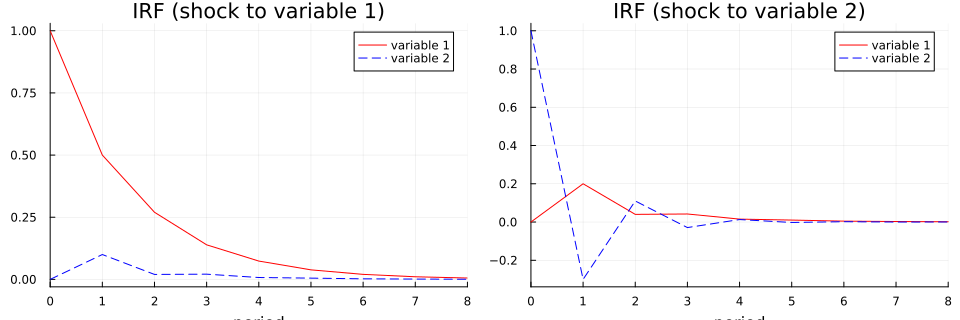

In [21]:
p1 = plot( period,IR_ϵ1,   #to traditional indices
           label = ["variable 1" "variable 2"],
           linecolor = [:red :blue],
           linestyle = [:solid :dash],
           xticks = period,
           xlims = (0,8),       #period 0 and onwards
           xlabel = "period",
           title = "IRF (shock to variable 1)" )

p2 = plot( period,IR_ϵ2,
           label = ["variable 1" "variable 2"],
           linecolor = [:red :blue],
           linestyle = [:solid :dash],
           xticks = period,
           xlims = (0,8),
           xlabel = "period",
           title = "IRF (shock to variable 2)" )

p = plot(p1,p2,layout=(1,2),size=(480*2,320))
display(p)

## Forecasting with a VAR Process

The cell below shows that forecasting with a VAR is very similar to forecasting with an AR: a simple recursive approach works well. However, for simplicity we will again use the `VARFilter()` function.

In [22]:
τ_max  = 11
period = -2:(τ_max-3)       #-2,-1,0,1,...

y0 = [1 2]
y2 = VARFilter(zeros(8,2),A1,y0)
y2 = [zeros(2,2);y0;y2]                      #pad with initial values

printmat(y2,colNames=["y1","y2"],rowNames=period,cell00="period")

period        y1        y2
-2         0.000     0.000
-1         0.000     0.000
0          1.000     2.000
1          0.900    -0.500
2          0.350     0.240
3          0.223    -0.037
4          0.104     0.033
5          0.059     0.000
6          0.029     0.006
7          0.016     0.001
8          0.008     0.001



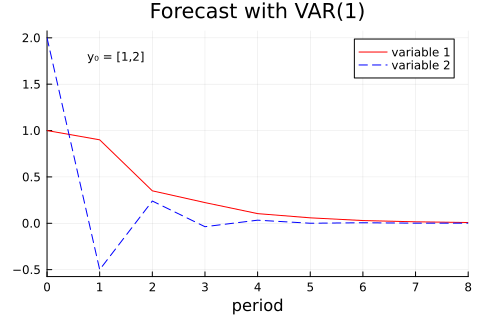

In [23]:
p1 = plot( period,y2,
           label = ["variable 1" "variable 2"],
           linecolor = [:red :blue],
           linestyle = [:solid :dash],
           xticks = period,
           xlims = (0,8),
           xlabel = "period",
           title = "Forecast with VAR(1)",
           annotate=(1.3,1.8,text("y₀ = [1,2]",8)) )
display(p1)

# Non-Stationary Processes

The cells below shows the impulse response function and the roots of a non-stationary AR(3).

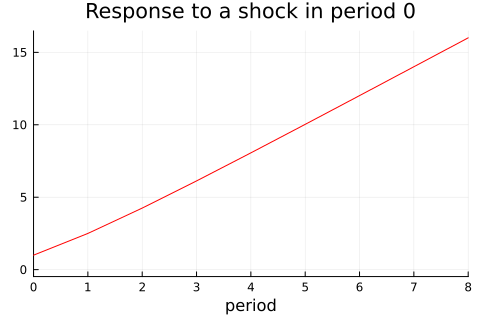

In [24]:
a = [2.5,-2,0.5]                      #AR(3) coefficients

τ_max  = 11
period = -2:(τ_max-3)       #-2,-1,0,1,...

ϵ    = zeros(τ_max)
ϵ[3] = 1                     #a single shock, otherwise zeros

y1 = ARMAFilter(ϵ,a)

p1 = plot( period,y1,
           label = "",
           linecolor = :red,
           xticks = period,
           xlims = (0,8),
           xlabel = "period",
           title = "Response to a shock in period 0" )
display(p1)

In [25]:
λ = eigen(CompanionFormAR(a)).values    #eigenvalues of the companion form

println("absolute values of the eigenvalues: should be < 1 for stationarity")
printmat(abs.(λ))

absolute values of the eigenvalues: should be < 1 for stationarity
     0.500
     1.000
     1.000

